In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from load_json import *

In [3]:
data = load_json_file('data.json')

In [4]:
data.head()

,Transcript,Position,dwelling_time_before,sd_before,mean_before,dwelling_time_current,sd_current,mean_current,dwelling_time_after,sd_after,mean_after
0,ENST00000000233,244,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270
1,ENST00000000233,261,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698
2,ENST00000000233,316,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324
3,ENST00000000233,332,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006102,2.236520,89.154000
4,ENST00000000233,368,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788


In [5]:
data['Position'] = data['Position'].astype(int)

In [6]:
labels = pd.read_csv('data.info')

In [7]:
labels.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [8]:
df = pd.merge(labels, data, left_on=['transcript_id', 'transcript_position'], right_on=['Transcript', 'Position'])

In [9]:
df = df.drop(['Transcript', 'Position'], axis = 1)

In [10]:
df.head()

,gene_id,transcript_id,transcript_position,label,dwelling_time_before,sd_before,mean_before,dwelling_time_current,sd_current,mean_current,dwelling_time_after,sd_after,mean_after
0,ENSG00000004059,ENST00000000233,244,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270
1,ENSG00000004059,ENST00000000233,261,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698
2,ENSG00000004059,ENST00000000233,316,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324
3,ENSG00000004059,ENST00000000233,332,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006102,2.236520,89.154000
4,ENSG00000004059,ENST00000000233,368,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788


In [11]:
df.shape

(121838, 13)

In [12]:
from sklearn.model_selection import GroupShuffleSplit 

In [13]:
splitter = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state = 7)
split = splitter.split(df, groups=df['gene_id'])
train_ind, test_ind = next(split)

train = df.iloc[train_ind]
test = df.iloc[test_ind]

In [14]:
X_train = train.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
y_train = train['label']
X_test = test.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
y_test = test['label']

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score

In [23]:
#fit KNN model where k = 60
k = 60
knn = KNeighborsClassifier(n_neighbors = k, n_jobs=-1).fit(X_train, y_train)

#predict on test set, with results and metrics shown
pred_y = knn.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred_y, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, pred_y),4))
print('Precision:', round(precision_score(y_test, pred_y),4))
print('Specificity:', round(specificity,4))
print('Recall',round(recall_score(y_test,pred_y),4))
print('F1-Score:', round(f1_score(y_test,pred_y),4))
print('AUC:',round(roc_auc_score(y_test, pred_y),4))

,True Y=0,True Y=1
Predicted Y=0,29298,1115
Predicted Y=1,101,236


Accuracy: 0.9605
Precision: 0.7003
Specificity: 0.9966
Recall 0.1747
F1-Score: 0.2796
AUC: 0.5856


In [24]:
#split the train data further into train and validation set
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7)
split = splitter.split(train, groups=train['gene_id'])
train_indx, val_indx = next(split)

training = train.iloc[train_indx]
val = train.iloc[val_indx]

In [25]:
train_x = training.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
train_y = training['label']
val_x = val.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
val_y = val['label']

In [26]:
%%time
#finding optimal value of k
error_rate = []

for i in range(1, 201, 10):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(train_x, train_y)
    pred_i = knn.predict(val_x)
    error_rate.append(np.mean(pred_i != val_y))

CPU times: user 53.5 s, sys: 867 ms, total: 54.4 s
Wall time: 15.6 s


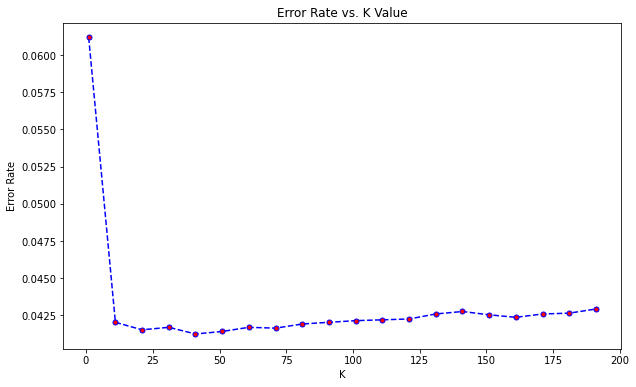

In [27]:
#plot graph of error rate against value of k
plt.figure(figsize=(10,6))
plt.plot(range(1, 201, 10), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=5)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.show()

In [28]:
knn.predict_proba(X_test)

array([[0.98429319, 0.01570681],
       [0.95287958, 0.04712042],
       [0.94764398, 0.05235602],
       ...,
       [0.95287958, 0.04712042],
       [0.96858639, 0.03141361],
       [1.        , 0.        ]])

In [29]:
pred_y

array([0, 0, 0, ..., 0, 0, 0])